<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Accumulate_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Tue May 26 17:35:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install Libraries

## Install EfficientNet

In [2]:
!pip install -U efficientnet

## Install Run:AI Gradient Accumulation library
https://github.com/run-ai/runai/tree/master/runai/ga

In [3]:
!pip install runai

# Import Libraries

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
import efficientnet.keras as enet
from keras.legacy import interfaces
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import runai.ga.keras

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

# Hyperparameters

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

BATCH_SIZE = 16
STEPS = 16
LR = 1e-3
EPOCHS = 100

# Data Preparation

In [7]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

Cloning into 'ham10000-with-one-image-folder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10045 (delta 4), reused 7 (delta 2), pack-reused 10036
Receiving objects: 100% (10045/10045), 2.57 GiB | 62.04 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (10022/10022), done.


In [ ]:
metadata_path = '/content/ham10000-with-one-image-folder/HAM10000_metadata.csv'
img_path = '/content/ham10000-with-one-image-folder/HAM1000_images'

In [ ]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
data = pd.read_csv(metadata_path)

In [ ]:
num_examples = data.values.shape[0]

In [ ]:
inputs = np.empty(shape=(num_examples, IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.float32)
labels = np.empty(shape=(num_examples), dtype=np.uint8)

## Resize to 224*224

In [ ]:
for i, row in enumerate(data.values):
    img_id = row[1]
    label = row[2]
    all_img_path = os.path.join(img_path, img_id) + '.jpg' 
    if (os.path.isfile(all_img_path)):
        im_path = all_img_path
    else:
        raise Exception ('File not found \'%s\'' %img_id)
    img = Image.open(im_path).resize((IMG_WIDTH, IMG_HEIGHT), Image.LANCZOS)
    inputs[i] = np.array(img)/255.0
    labels[i] = label_names.index(label)

## Split Data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1, random_state=555)

del inputs
del labels

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=555)

In [15]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(6309, 224, 224, 3) (6309,)
(2704, 224, 224, 3) (2704,)
(1002, 224, 224, 3) (1002,)


## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=360,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect')

In [ ]:
datagen.fit(x_train)

# Adam Accumulate

In [17]:
ga_optimizer = runai.ga.keras.optimizers.Optimizer(Adam(LR), steps=STEPS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [26-05-2020 17:46:40.165] [138] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


# Build Model
DenseNet121 + fine tuning

In [ ]:
def build_model():
  base_model = enet.EfficientNetB0(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')

  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)

  x = BatchNormalization()(average_pooling_layer)
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  x = Dense(128, activation='relu')(x)
  x = BatchNormalization()(x)

  prediction_layer = Dense(units=7, activation='softmax', name='prediction')(x)

  model = Model(inputs=base_model.input, outputs=prediction_layer)

  model.compile(optimizer=ga_optimizer, 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
model = build_model()

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

### Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='acc_effnet_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-5 , patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [40]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_val, y_val, compute_sample_weight('balanced', y_val)),
                              class_weight=compute_class_weight('balanced', np.unique(y_train), y_train),
                              steps_per_epoch=math.ceil(x_train.shape[0]/BATCH_SIZE),
                              epochs=EPOCHS,
                              callbacks=[early_stop, model_checkpoint, reduce_lr_rate])


Epoch 1/100
395/395 [==============================] - 93s 234ms/step - loss: 1.5746 - accuracy: 0.5633 - val_loss: 1.9050 - val_accuracy: 0.7408
Epoch 2/100
395/395 [==============================] - 68s 173ms/step - loss: 1.0678 - accuracy: 0.7150 - val_loss: 1.3487 - val_accuracy: 0.7936
Epoch 3/100
395/395 [==============================] - 68s 173ms/step - loss: 0.9298 - accuracy: 0.7404 - val_loss: 1.1723 - val_accuracy: 0.8229
Epoch 4/100
395/395 [==============================] - 69s 174ms/step - loss: 0.7998 - accuracy: 0.7710 - val_loss: 1.2834 - val_accuracy: 0.8169
Epoch 5/100
395/395 [==============================] - 69s 174ms/step - loss: 0.7463 - accuracy: 0.7754 - val_loss: 1.1596 - val_accuracy: 0.8184
Epoch 6/100
395/395 [==============================] - 69s 174ms/step - loss: 0.7219 - accuracy: 0.7802 - val_loss: 1.0480 - val_accuracy: 0.8210
Epoch 7/100
395/395 [==============================] - 70s 177ms/step - loss: 0.6717 - accuracy: 0.7884 - val_loss: 1.0155 

# Graph

## Accuracy

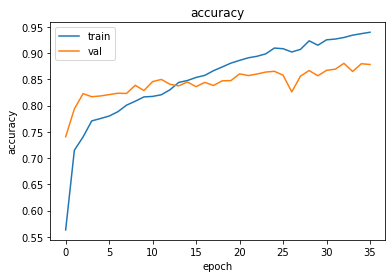

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

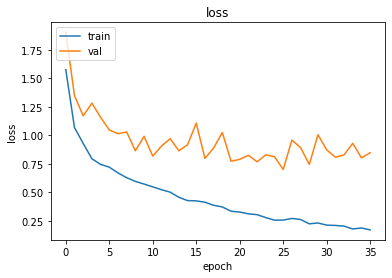

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [ ]:
test_model = load_model('/content/acc_effnet_model.h5', compile=False)

In [44]:
y_pred = np.argmax(test_model.predict(x_test), axis=1)
print('balanced acc on test set:', balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

balanced acc on test set: 0.7635610187322194


## Classification Report

In [45]:
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=label_names)
print(report)

              precision    recall  f1-score   support

       akiec       0.78      0.55      0.64        33
         bcc       0.79      0.76      0.77        41
         bkl       0.70      0.73      0.71        99
          df       0.79      0.85      0.81        13
         mel       0.64      0.66      0.65       118
          nv       0.92      0.93      0.92       681
        vasc       1.00      0.88      0.94        17

    accuracy                           0.85      1002
   macro avg       0.80      0.76      0.78      1002
weighted avg       0.85      0.85      0.85      1002



## Confusion Matrix

Confusion matrix, without normalization
[[ 18   2  10   0   3   0   0]
 [  0  31   3   1   0   6   0]
 [  1   2  72   0   6  18   0]
 [  0   0   0  11   1   1   0]
 [  1   2   7   0  78  30   0]
 [  3   2  11   2  32 631   0]
 [  0   0   0   0   1   1  15]]


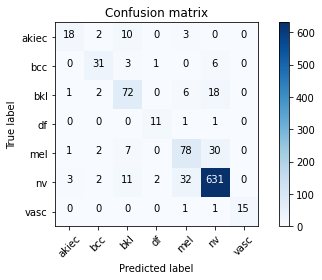

In [46]:
cm = (confusion_matrix(y_true=y_test, y_pred=y_pred))

plot_confusion_matrix(cm, label_names)

## Sensitivity & Specificity

In [ ]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [48]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.9000
specificity: 1.0000


# Grad-CAM

In [ ]:
last_conv2d = 'top_conv'

## AKIEC

In [ ]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.990
	vasc           	(6)	with probability 0.003
	df             	(3)	with probability 0.002
	bkl            	(2)	with probability 0.002
	nv             	(5)	with probability 0.001
Explanation for 'mel'


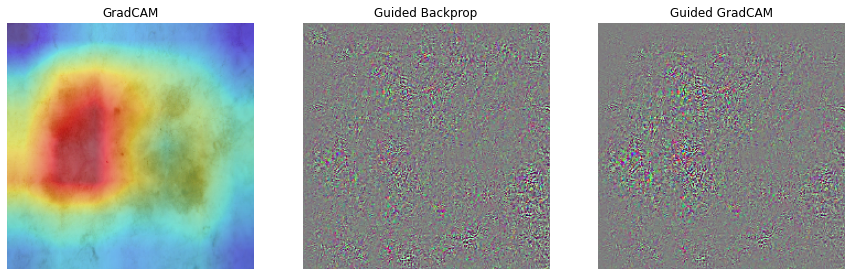

In [51]:
radcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

## BCC

In [ ]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	nv             	(5)	with probability 0.460
	bcc            	(1)	with probability 0.270
	akiec          	(0)	with probability 0.187
	mel            	(4)	with probability 0.049
	vasc           	(6)	with probability 0.022
Explanation for 'nv'


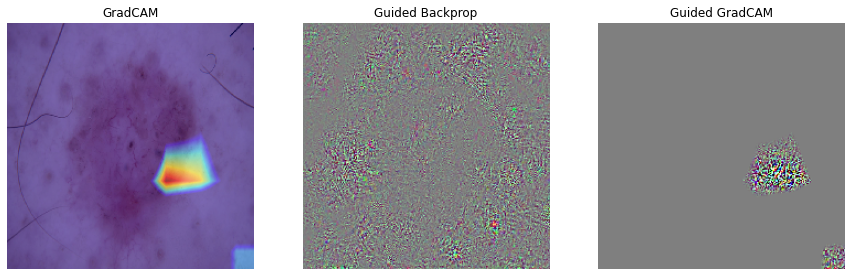

In [53]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

In [ ]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.548
	nv             	(5)	with probability 0.452
	df             	(3)	with probability 0.000
	vasc           	(6)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'mel'


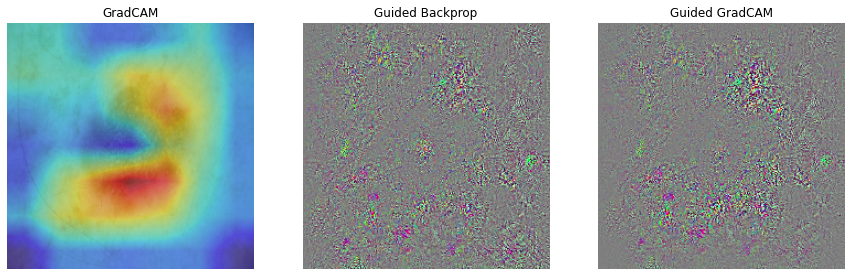

In [55]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

## DF

In [ ]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.981
	nv             	(5)	with probability 0.018
	df             	(3)	with probability 0.001
	vasc           	(6)	with probability 0.000
	bcc            	(1)	with probability 0.000
Explanation for 'mel'


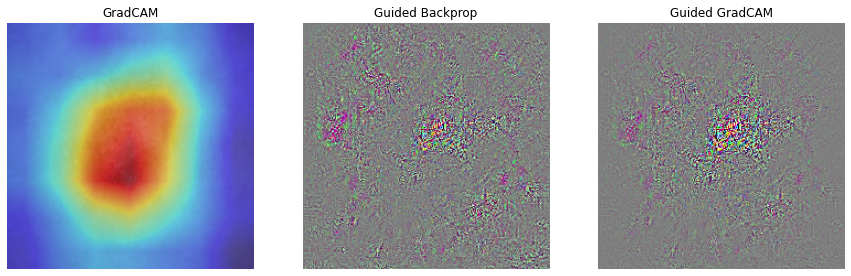

In [57]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

## MEL

In [ ]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	nv             	(5)	with probability 0.991
	mel            	(4)	with probability 0.009
	vasc           	(6)	with probability 0.000
	df             	(3)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'nv'


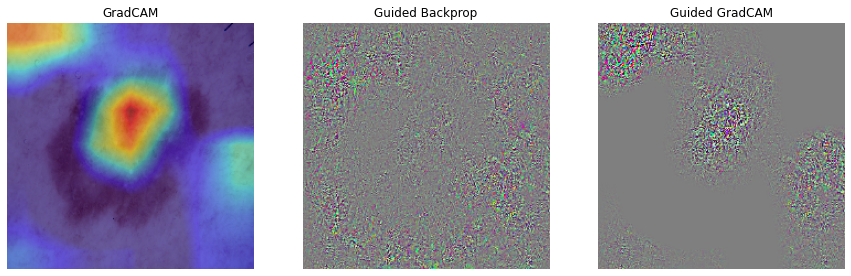

In [59]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

## NV

In [ ]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	nv             	(5)	with probability 1.000
	vasc           	(6)	with probability 0.000
	mel            	(4)	with probability 0.000
	df             	(3)	with probability 0.000
	bcc            	(1)	with probability 0.000
Explanation for 'nv'


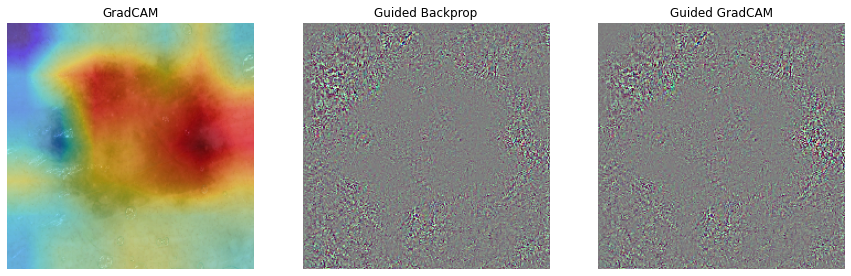

In [61]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

## VASC

In [ ]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	nv             	(5)	with probability 1.000
	vasc           	(6)	with probability 0.000
	df             	(3)	with probability 0.000
	bcc            	(1)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'nv'


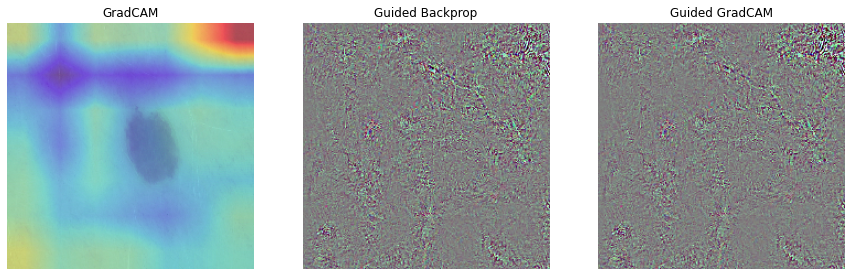

In [63]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# Download Model

In [ ]:
from google.colab import files

In [ ]:
files.download('/content/acc_effnet_model.h5')